In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=89, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,40,0.01,0.396576,0.730940,200,1,2354,0.050
1,40,0.01,0.445240,0.829526,200,1,2362,0.020
2,40,0.05,0.397664,0.738769,200,1,2366,0.050
3,40,0.05,0.467016,0.869076,200,1,2353,0.010
4,40,0.02,0.461092,0.861722,200,1,2363,0.010
5,35,0.01,0.419955,0.804016,200,1,2350,0.010
6,40,0.01,0.458939,0.868018,200,1,2351,0.010
7,45,0.01,0.480687,0.928956,200,1,2352,0.010
8,45,0.05,0.473385,0.912385,50,1,2156,0.010
9,45,0.01,0.464178,0.878157,50,1,2155,0.010


In [3]:
run_id = 2350
# for ISIE talk: run_id = 1749

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3933832.44997399}


,topic__id,topic__title,totalscore
0,184089,stop words,419821.116446
1,184090,procedural,367744.157874
2,184081,economic policy,216063.202495
3,184105,federal government,158838.262969
4,184102,policy statements,156957.446933
5,184106,budget,148827.974002
6,184086,European Coal and Steel Community,144982.504003
7,184098,international cooperation,142685.511866
8,184108,energy policy,134634.299691
9,184097,procedural 2,124332.949316


### Overall DocTopic score - Time plot

In [4]:
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_scores

topic,European Coal and Steel Community,agricultural policy,budget,budget 2,climate protection,coal mining,coal policy & prices,debate government policy,economic policy,economic policy & participation,...,procedural,procedural 2,research & development,reunification,risks of nuclear energy,stop words,structural adjustment,subsidy reduction,tax policy,transport policy
parlperiod,,,,,,,,,,,,,,,,,,,,,
1,82349.501906,6075.067415,8808.920749,568.410879,133.509431,1203.456920,32549.026092,150.058039,19527.988686,19789.142870,...,29570.854228,5753.340716,610.013087,922.281888,212.766429,34871.676295,3188.165862,358.034158,10550.394510,8859.196201
2,22120.041003,11746.123703,10371.860697,892.688278,17.090793,1861.159903,17294.711048,169.451466,24322.678377,12796.307571,...,32409.030139,6726.732726,835.735827,313.188712,3719.846395,27966.162279,826.408031,139.018589,4918.252851,25613.350759
3,4961.588324,6062.651433,15792.286786,1085.678927,41.316981,4956.503596,22657.844169,117.760484,17077.986502,10858.057584,...,17488.523667,5987.360267,536.776650,186.005579,1175.932566,22525.190183,630.533994,280.763891,4515.475153,12501.701518
4,5673.928909,7495.179284,13990.198525,773.740105,11.591260,11738.744518,8945.621078,49.152969,12161.850947,5196.464497,...,18788.790099,4324.711398,413.059816,171.682336,325.825542,15703.164858,838.794467,116.232722,2632.750128,7260.055793
5,5829.877829,9735.347258,23592.621252,2030.585239,28.205642,23042.731360,5556.741521,165.071746,27829.584234,4208.738350,...,41199.330774,12518.176387,3264.254635,237.413062,2606.525427,28573.695703,4145.890465,416.471753,4268.223532,7281.799161
6,926.608580,1065.395238,5049.703827,1616.695931,14.282931,1748.231997,1359.335713,50.174365,3389.087215,1958.799231,...,7000.517929,8427.062292,1072.070947,89.480913,555.089428,4633.578567,1129.971308,28.598703,1179.077130,1151.901138
7,1866.178929,602.035243,9564.657965,7020.779149,40.507234,3401.591728,4003.848757,101.867724,11545.858097,3993.426266,...,25420.252463,16989.894766,6434.143469,431.435108,5428.793496,14538.858250,1081.705529,98.030403,3058.782732,1407.219583
8,1697.505582,839.932809,8253.339384,11074.263889,78.545343,2936.949468,2654.949400,861.655985,16766.369416,2914.362513,...,34080.125027,7794.837897,6655.047279,435.831256,10410.543462,22886.779974,3354.051169,534.486899,5575.587174,1195.021452
9,793.854367,716.739409,6336.952230,13496.975072,45.622223,945.164826,947.573386,735.565518,10582.879805,2620.131920,...,16739.629201,1711.687473,3759.572864,748.754320,5129.947894,18802.583964,1881.250505,495.473508,2614.180030,556.799025


In [5]:
# normalization
df_shares = df_scores.copy()
for i in df_shares.index:
    df_shares.loc[i] = df_scores.loc[i] / df_scores.loc[i].sum() * 100
df_shares

topic,European Coal and Steel Community,agricultural policy,budget,budget 2,climate protection,coal mining,coal policy & prices,debate government policy,economic policy,economic policy & participation,...,procedural,procedural 2,research & development,reunification,risks of nuclear energy,stop words,structural adjustment,subsidy reduction,tax policy,transport policy
parlperiod,,,,,,,,,,,,,,,,,,,,,
1,23.461948,1.730829,2.509723,0.161944,0.038038,0.342873,9.273445,0.042753,5.563660,5.638065,...,8.424943,1.639167,0.173797,0.262765,0.060619,9.935184,0.908331,0.102006,3.005881,2.524047
2,8.466836,4.496036,3.970013,0.341692,0.006542,0.712392,6.619856,0.064861,9.309934,4.898013,...,12.405128,2.574776,0.319893,0.119879,1.423837,10.704542,0.316322,0.053212,1.882548,9.803962
3,2.660372,3.250755,8.467723,0.582134,0.022154,2.657646,12.148991,0.063142,9.157107,5.822021,...,9.377235,3.210384,0.287816,0.099735,0.630528,12.077863,0.338088,0.150544,2.421169,6.703332
4,3.958216,5.228747,9.759768,0.539772,0.008086,8.189121,6.240597,0.034290,8.484286,3.625130,...,13.107336,3.016982,0.288157,0.119768,0.227301,10.954759,0.585155,0.081086,1.836645,5.064722
5,2.112327,3.527388,8.548265,0.735738,0.010220,8.349024,2.013362,0.059810,10.083435,1.524943,...,14.927667,4.535685,1.182731,0.086021,0.944417,10.353047,1.502172,0.150899,1.546496,2.638399
6,1.478742,1.700227,8.058645,2.580028,0.022794,2.789942,2.169316,0.080072,5.408525,3.125979,...,11.171880,13.448452,1.710880,0.142799,0.885848,7.394565,1.803281,0.045640,1.881648,1.838278
7,1.027658,0.331526,5.267020,3.866169,0.022306,1.873172,2.204820,0.056096,6.358018,2.199081,...,13.998303,9.355914,3.543123,0.237581,2.989502,8.006189,0.595668,0.053983,1.684396,0.774921
8,0.662607,0.327861,3.221620,4.322744,0.030659,1.146413,1.036337,0.336340,6.544608,1.137596,...,13.302883,3.042648,2.597740,0.170123,4.063666,8.933658,1.309225,0.208632,2.176382,0.466466
9,0.500342,0.451738,3.993982,8.506720,0.028754,0.595708,0.597226,0.463604,6.670057,1.651387,...,10.550464,1.078823,2.369541,0.471916,3.233245,11.850679,1.185693,0.312281,1.647636,0.350933


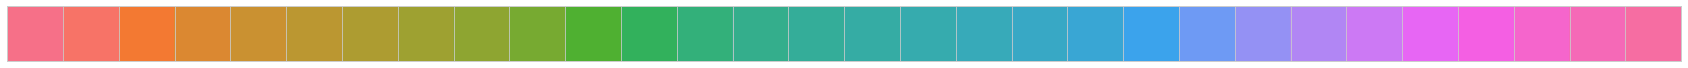

In [6]:
%matplotlib inline
# figure aesthetics
sns.set_style('whitegrid')
plt.rcParams['lines.linewidth'] = 3

sns.set_palette('husl', 30)
#sns.set_palette('muted')
sns.palplot(sns.color_palette())

In [7]:
def time_evolution_plot(dfs, filename, title=None, scale=1):
    
    sns.set_context("talk")
    sns.set_style("ticks")
    sns.set_style({'axes.spines.bottom': True,
                   'axes.grid':True,
                   'axes.spines.left': False,
                   'axes.spines.right': False,
                   'axes.spines.top': False,
                   'ytick.left': False,
                   'figure.facecolor':'w'})


    fig = plt.figure(figsize=(10, 0.7 * len(dfs.columns)))
    ax = fig.gca()
    #ax.autoscale(enable=False)
    #ax.set_ylim([0 - max_val, len(dfs.index) + max_val])
    #ax.set(ylim=(0 - max_val, len(dfs.index) + max_val))
    plt.yticks([])
    plt.xticks(range(1,20))

    max_val = scale * dfs.max().max() + 5
    #print(max_val)

    for i, t in enumerate(reversed(dfs.columns)):
        plt.fill_between(dfs.index, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
        plt.text(19.3, (i+0.) *max_val, t)

    plt.xlabel('Parliamentary period')
    if title:
        plt.title(title)
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    
def get_sorted_columns(df):
    
    # sort according to position of peak
    sel2 = df.copy()
    sel2.loc['peak_pos'] = [sel2[topic].idxmax() for topic in sel2.columns]
    sel2 = sel2.sort_values(by='peak_pos', axis=1)
    sel2 = sel2.drop('peak_pos')
    return sel2.columns

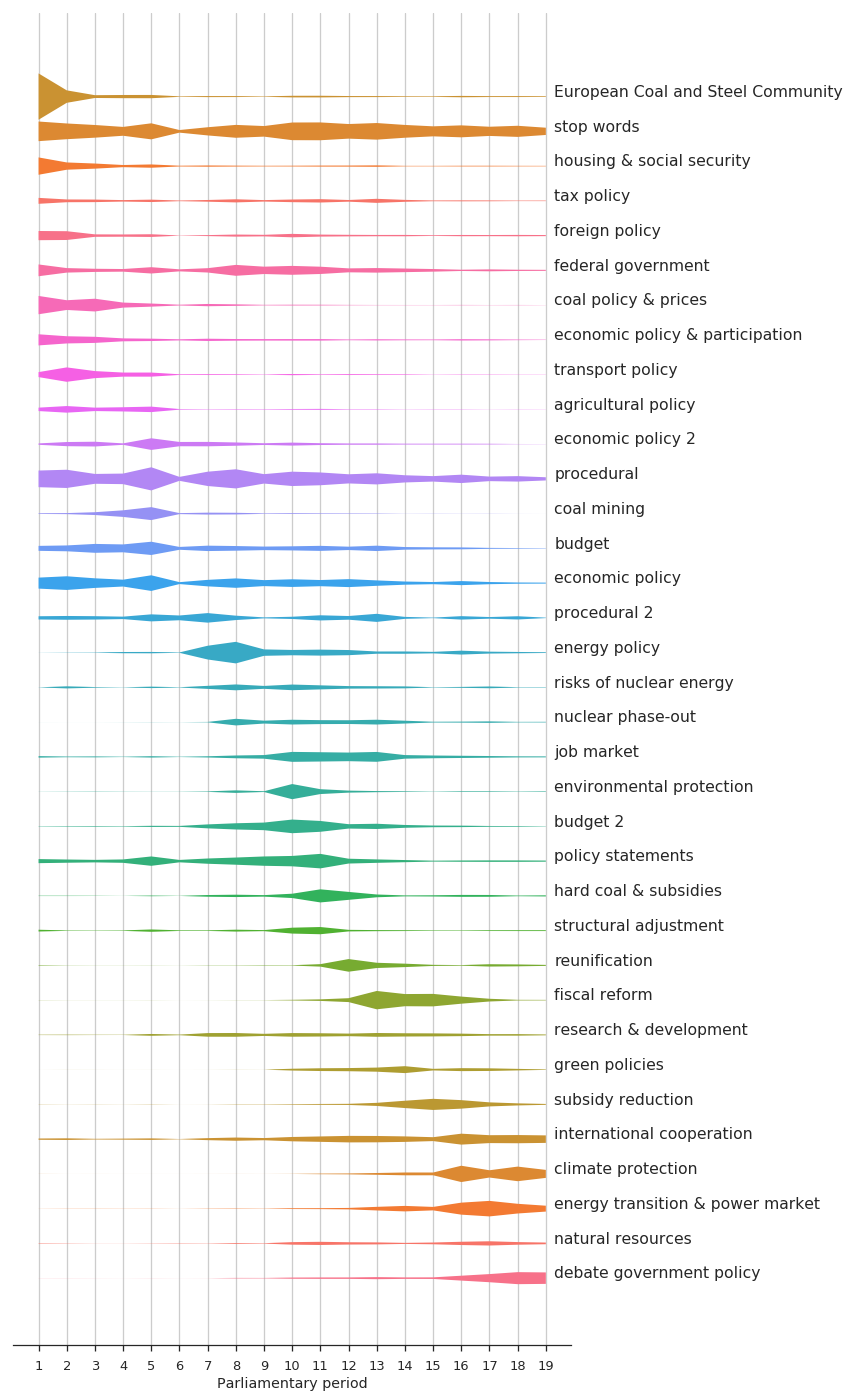

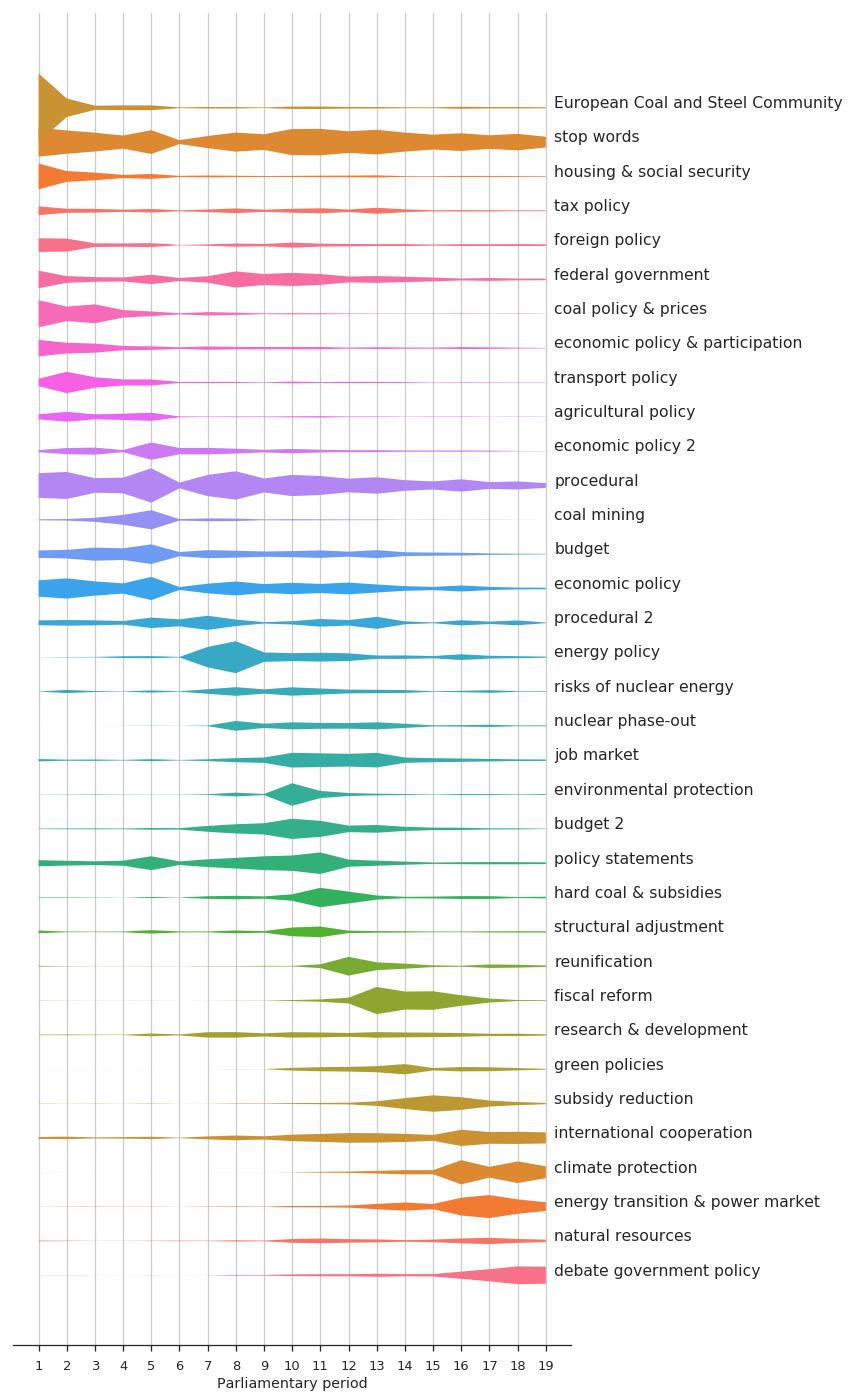

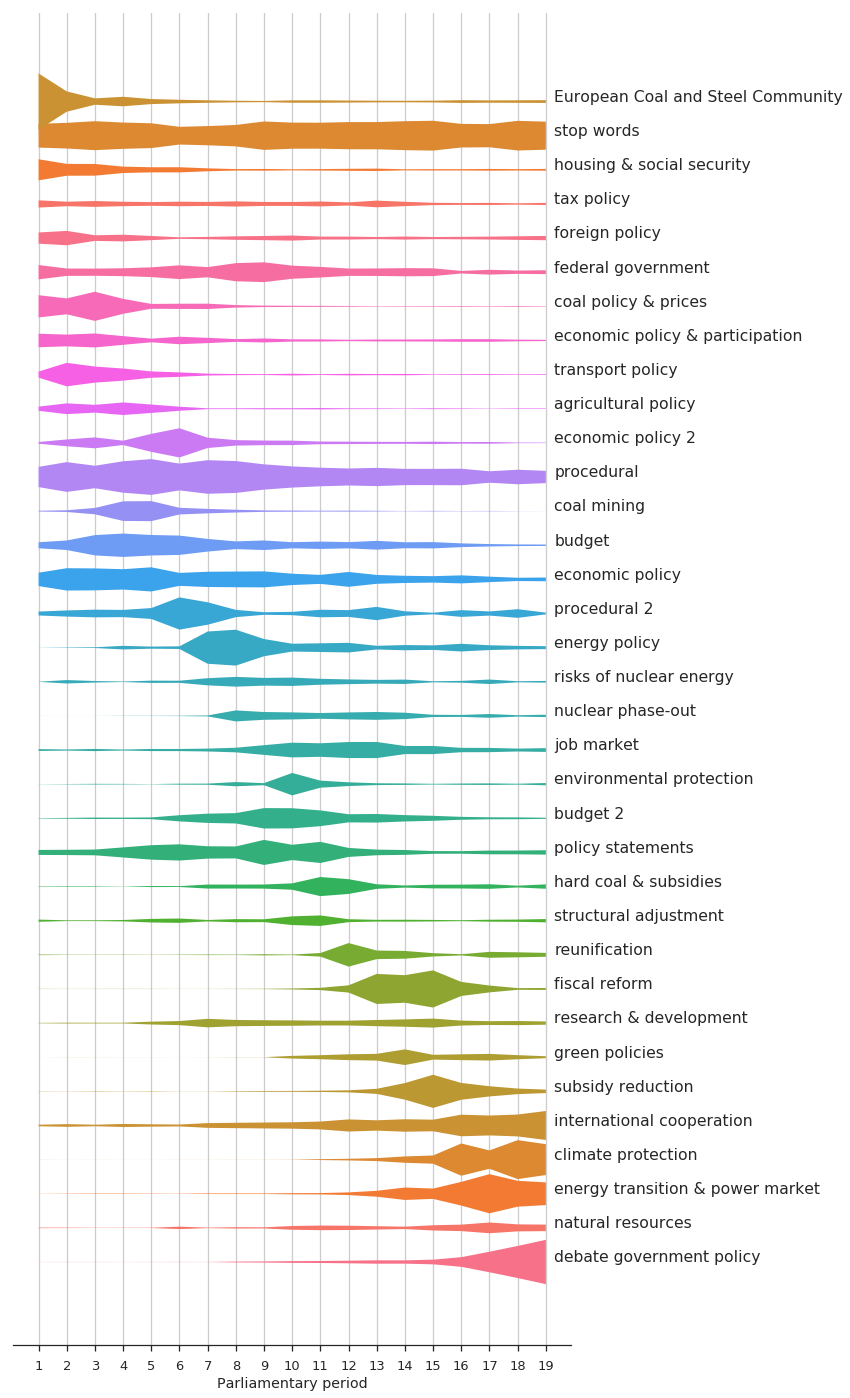

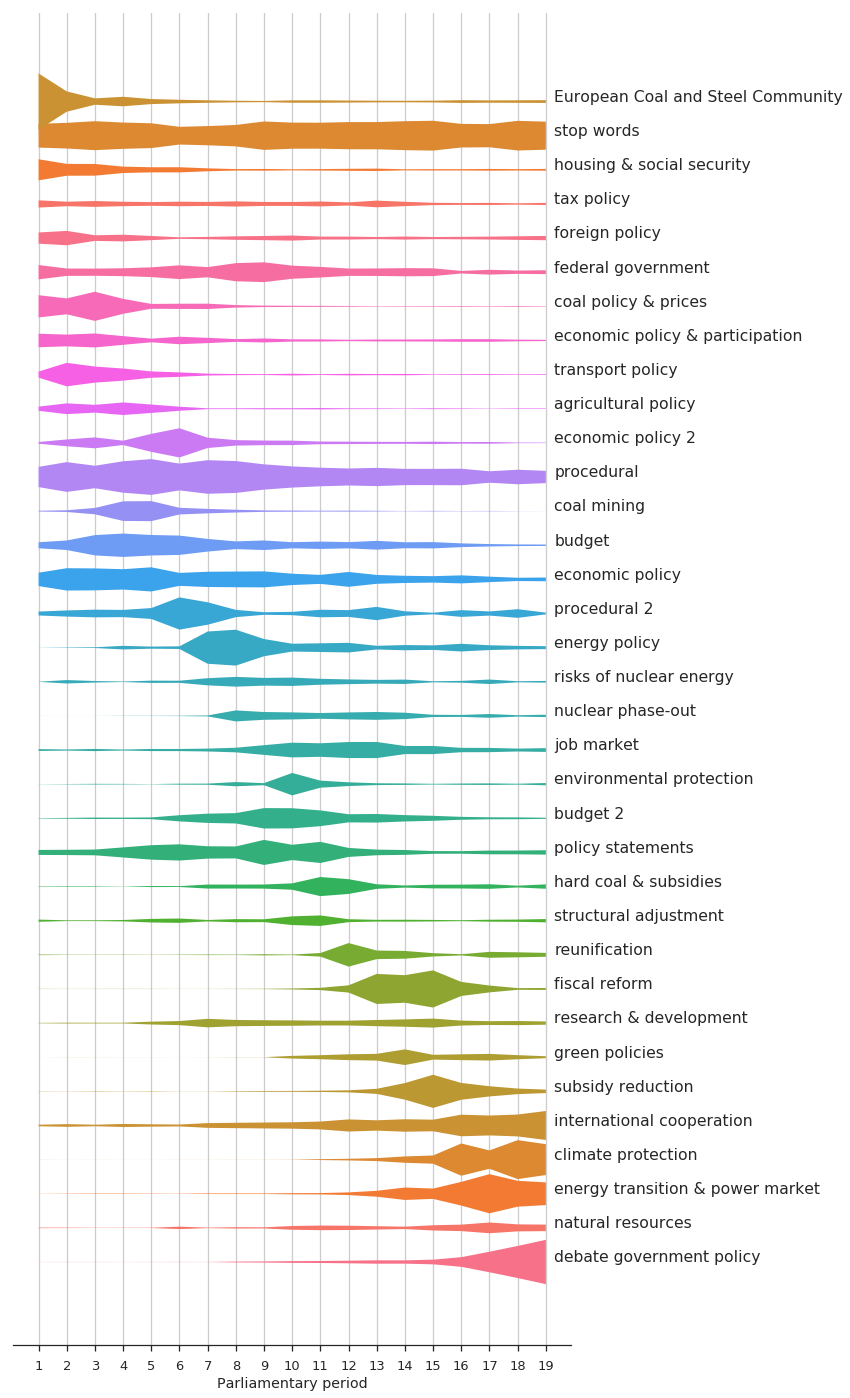

In [23]:
#dfs = df[["EU", "finance"]]
#dfs = df_shares[["hard coal mining",  "EU", "energy transition 3", "energy transition 2", "energy transition",
#          "economy & jobs", "east germany", "development", "climate protection", "climate policy"]]
#print(dfs)

# for poster plot
#selection = ["agriculture", "coal mining industry", "diplomacy & trade",
#                 "east germany", "energy technology",
#                 "hard coal mining", "international climate protection",
#                 "pollution control", "research & development", "subsidies"]

selection = ["European Coal and Steel Community", "coal policy & prices", "agricultural policy",
                 "coal mining", "energy policy", "reunification",
                 "subsidy reduction", "climate protection", "energy transition & power market"]

sorted_selection = get_sorted_columns(df_scores)
sorted_all = get_sorted_columns(df_scores)

# plot scores
time_evolution_plot(df_scores[sorted_selection], os.path.join(save_dir, 'topic_evolution_scores_run{}_selection.png'.format(run_id)), scale=1.5)
time_evolution_plot(df_scores[sorted_all], os.path.join(save_dir, 'topic_evolution_scores_run{}_all.png'.format(run_id)))

# plot shares
time_evolution_plot(df_shares[sorted_selection], os.path.join(save_dir, 'topic_evolution_shares_run{}_selection.png'.format(run_id)))
time_evolution_plot(df_shares[sorted_all], os.path.join(save_dir, 'topic_evolution_shares_run{}_all.png'.format(run_id)))

In [24]:
sorted_selection

Index(['European Coal and Steel Community', 'stop words',
       'housing & social security', 'tax policy', 'foreign policy',
       'federal government', 'coal policy & prices',
       'economic policy & participation', 'transport policy',
       'agricultural policy', 'economic policy 2', 'procedural', 'coal mining',
       'budget', 'economic policy', 'procedural 2', 'energy policy',
       'risks of nuclear energy', 'nuclear phase-out', 'job market',
       'environmental protection', 'budget 2', 'policy statements',
       'hard coal & subsidies', 'structural adjustment', 'reunification',
       'fiscal reform', 'research & development', 'green policies',
       'subsidy reduction', 'international cooperation', 'climate protection',
       'energy transition & power market', 'natural resources',
       'debate government policy'],
      dtype='object', name='topic')

--------------------------------------------------

In [25]:
topic_dir = "plots/topic_analysis_{}/".format(run_id)
topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
#selected_topics = topic_classification[topic_classification['classification'] != 'procedural and general politics']['label'].values

In [26]:
# normalization with selection
sel_shares = df_scores[sorted_selection].copy()

for i in sel_shares.index:
    sum_score = sel_shares.loc[i].sum()
    sel_shares.loc[i] = sel_shares.loc[i] / sum_score * 100

# sel_shares.dtypes

sel_shares = sel_shares[get_sorted_columns(sel_shares)]

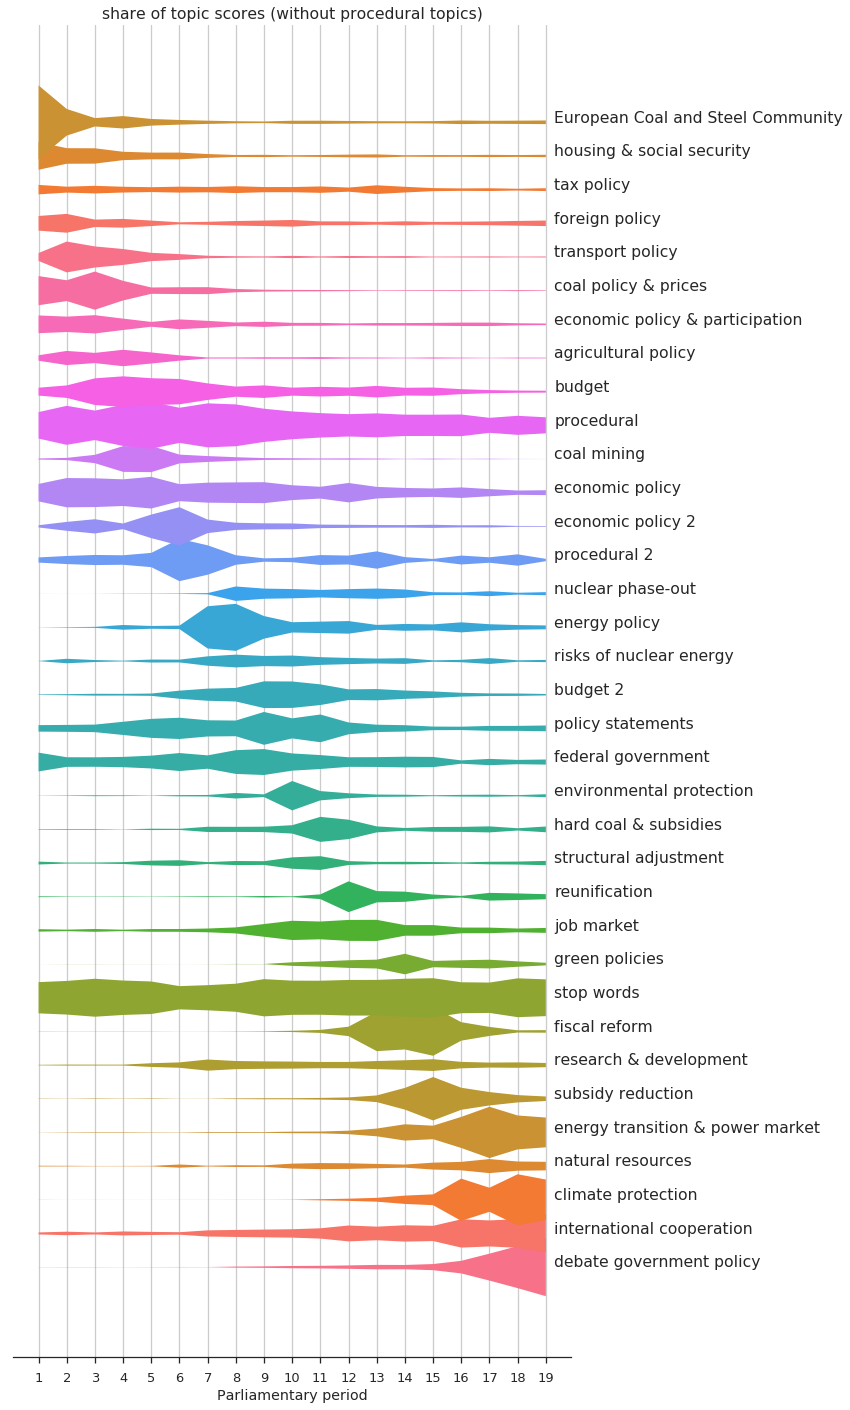

In [27]:
#sel_shares = df_scores[selected_topics].copy()

time_evolution_plot(sel_shares, os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural.png'.format(run_id)),
                   title='share of topic scores (without procedural topics)', scale=0.7)

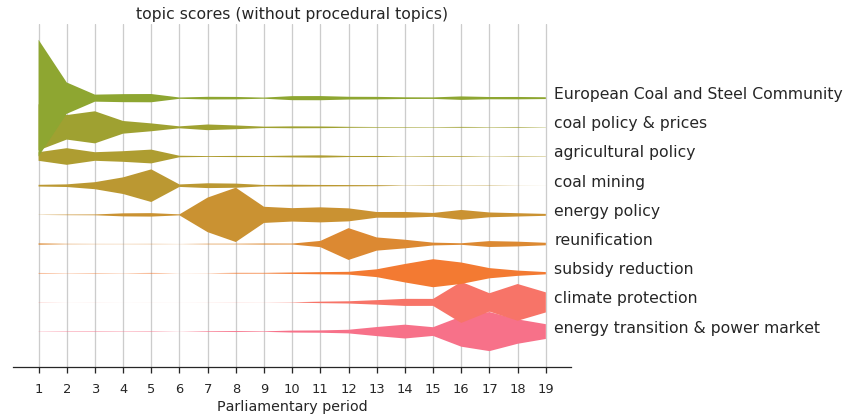

In [28]:
time_evolution_plot(df_scores[get_sorted_columns(df_scores[selection])], os.path.join(save_dir, 'topic_evolution_scores_run{}_wo_procedural.png'.format(run_id)),
                   title='topic scores (without procedural topics)', scale=0.5)

In [29]:
topic_classes = set(topic_classification['classification'])
print(topic_classes)

{'economy and finance', 'environment', 'international and regional', 'energy', 'procedural and general politics', 'economy and budget'}


In [30]:
topic_classes = ['economy and budget', 'energy', 'environment', 'international and regional']

index = pd.Index([])

for topic_class in topic_classes:
    topics_in_class = topic_classification[topic_classification['classification'] == topic_class]['label'].values
        
    index = index.append(get_sorted_columns(sel_shares[topics_in_class]))

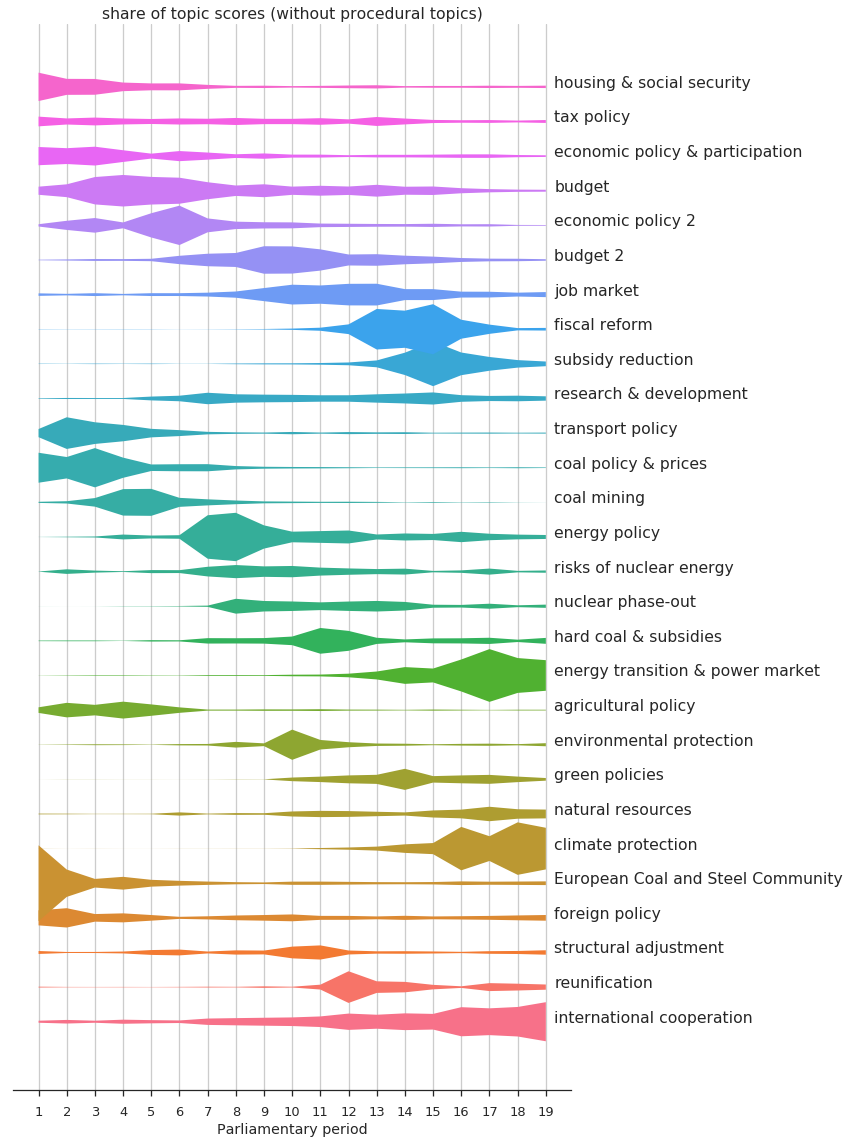

In [31]:
time_evolution_plot(sel_shares[index], os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural.png'.format(run_id)),
                   title='share of topic scores (without procedural topics)', scale=0.7)

# the same as a barplot and transposed

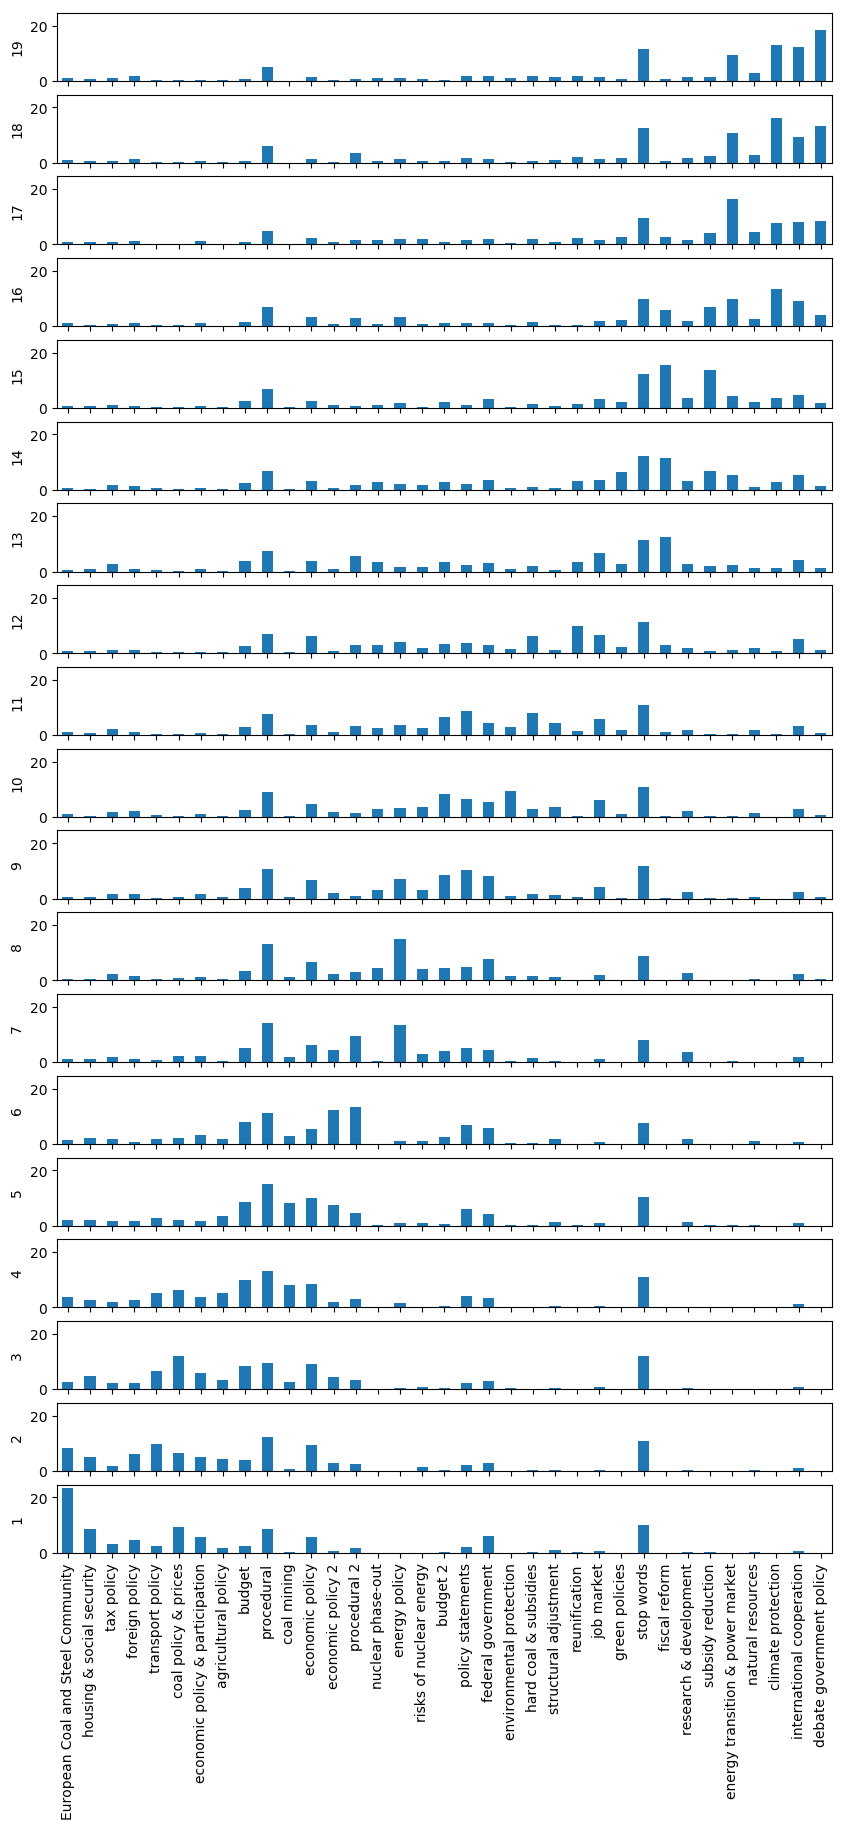

In [32]:
sns.reset_orig()
fig, ax = plt.subplots(19, 1, sharex=True, sharey=True, figsize=(10, 20))
pp_to_pos = {i: 19 - i for i in range(19, 0, -1)}

for i in range(1, 20):
    sel_shares.loc[i].plot.bar(ax=ax[pp_to_pos[i]])
    ax[pp_to_pos[i]].set_ylabel(i)

ax[18].set_xlabel("")
plt.savefig(os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural_barplot_simple.png'.format(run_id)))

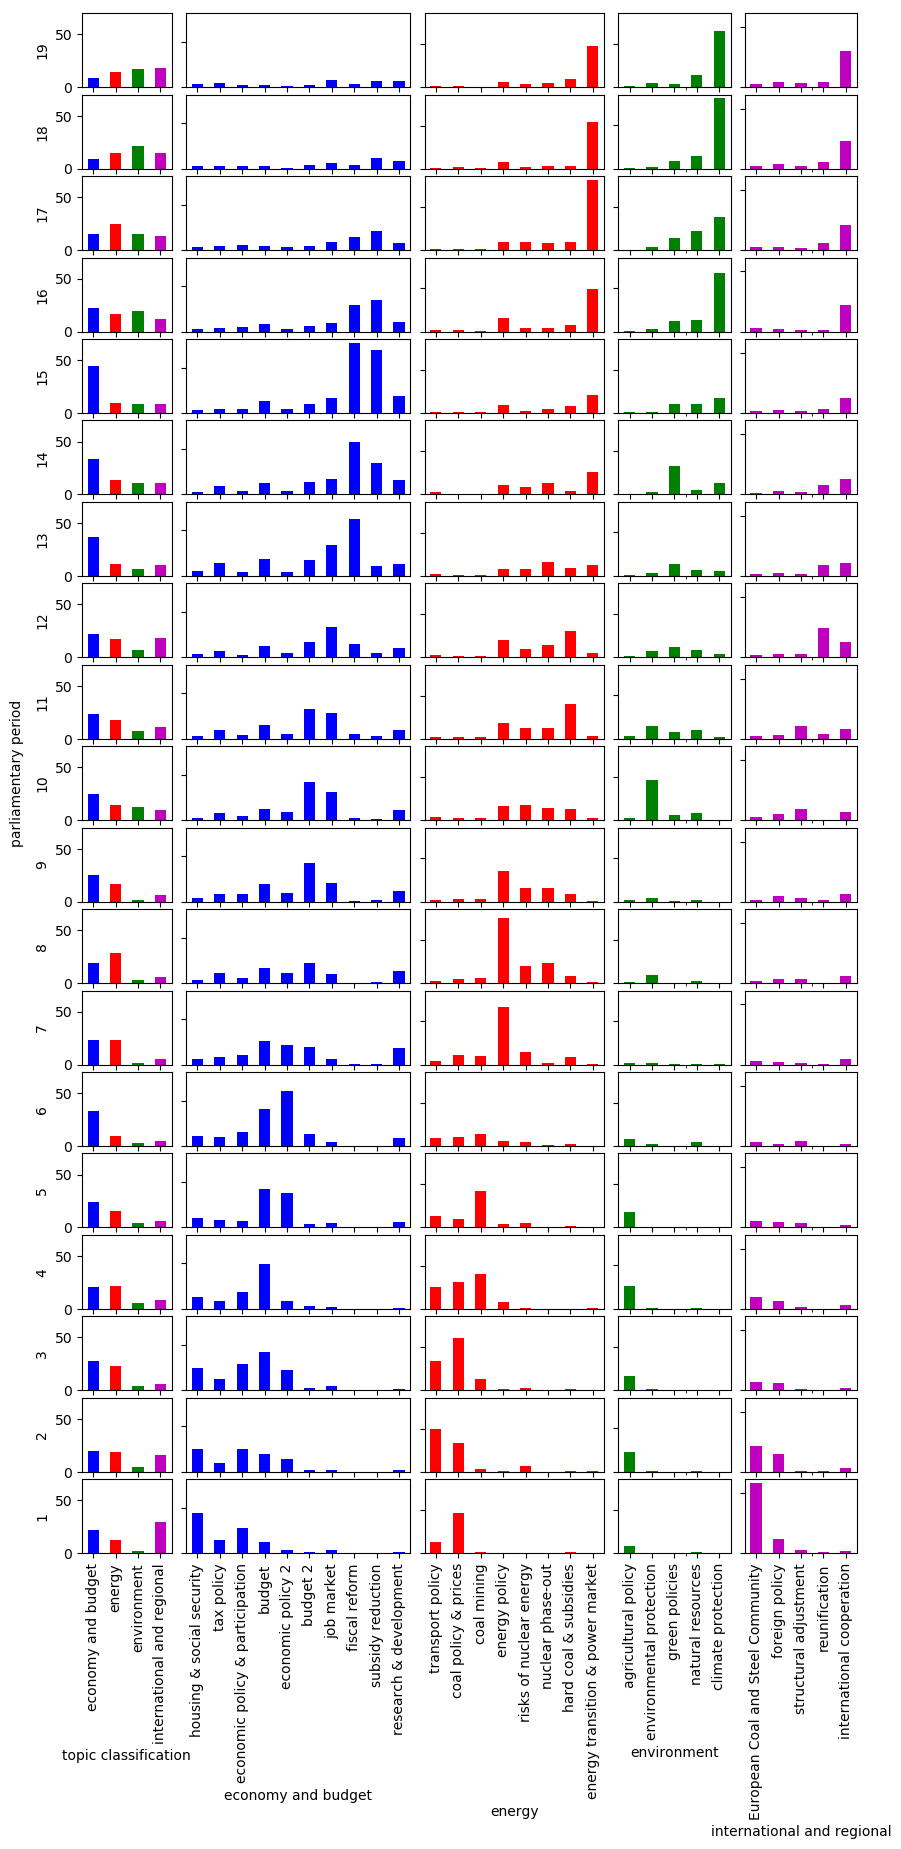

In [33]:
sns.reset_orig()

topics_per_class = []
for topic_class in topic_classes:
    topics_in_class = topic_classification[topic_classification['classification'] == topic_class]['label'].values
    topics_per_class.append(len(topics_in_class))

topics_per_class.insert(0, len(topic_classes))

fig, ax = plt.subplots(19, len(topic_classes) + 1, sharex='col', sharey='col',
                       figsize=(10, 20), gridspec_kw={'width_ratios': topics_per_class})

pp_to_pos = {i: 19 - i for i in range(19, 0, -1)}
colors = ["b", "r", "g", "m"]

class_shares = pd.DataFrame(index=sel_shares.index, columns=topic_classes)

for j, topic_class in enumerate(topic_classes):
    topics_in_class = topic_classification[topic_classification['classification'] == topic_class]['label'].values

    sel = sel_shares[topics_in_class]
    sel = sel[get_sorted_columns(sel)]
    for i in range(1, 20):
        sel.loc[i].plot.bar(ax=ax[pp_to_pos[i]][j+1], color=colors[j])
        ax[pp_to_pos[i]][j+1].set_ylabel(i)
        #ax[pp_to_pos[i]][0].set_ylim([0, 20])

        class_shares.loc[i, topic_class] = sel.loc[i].sum()
        
    ax[18][j+1].set_xlabel(topic_class)

    
for i in range(1, 20):
    class_shares.loc[i].plot.bar(ax=ax[pp_to_pos[i]][0], color=colors)
    ax[pp_to_pos[i]][0].set_ylabel(i)
    ax[pp_to_pos[i]][0].set_ylim([0, 70])

ax[18][0].set_xlabel("topic classification")
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.text(0.06, 0.5, 'parliamentary period', ha='center', va='center', rotation='vertical')
plt.savefig(os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural_barplot.png'.format(run_id)),
           dpi=150, bbox_inches="tight")

----------------------------------------------------------------